In [47]:
import numpy as np

def w_init(params):
    """
    w, b are lists. Their i^th element corresponds to the i^th
    weights/biases of the network. For example, the first element
    corresponds to the first weights/biases that convey information from input
    to the first hidden layer of the network.
    params is a dictionary of parameters.
    type is the type of non-linearity.
    n_layers is the number of layers in the network.
    neurons is a list with the i^th element being the number of neurons in the i^th
    layer.
    """

    type_ = params['type']
    n_layers = params['n_layers']
    neurons = params['neurons']

    w = [None] * (n_layers - 1)
    b = [None] * (n_layers - 1)

    for i in range(n_layers - 1):
        norm_b = 0
        if type_ == 'lin':
            norm_w = np.sqrt(1 / (neurons[i + 1] + neurons[i]))
        elif type_ == 'tanh':
            norm_w = np.sqrt(6 / (neurons[i + 1] + neurons[i]))
        elif type_ == 'logsig':
            norm_w = 4 * np.sqrt(6 / (neurons[i + 1] + neurons[i]))
        elif type_ == 'reclin':
            norm_w = np.sqrt(1 / (neurons[i + 1] + neurons[i]))
            norm_b = 0.1

        w[i] = np.random.uniform(-1, 1, (neurons[i + 1], neurons[i])) * norm_w

        print('Init weights:')
        print(w[i])
        print()

        b[i] = np.zeros((neurons[i + 1], 1)) + norm_b * np.ones((neurons[i + 1], 1))

    return w, b


In [48]:
def f(x, type_):
    """
    Apply an activation function to a layer of neurons.

    Args:
        x: A column vector (1D numpy array) of neurons from a particular layer.
        type_: A string indicating the type of activation function.

    Returns:
        m: The result after applying the activation function, always as a 2D column vector.
    """

    # Ensure x is a 2D column vector for consistent operations
    x_col_vec = x.reshape(-1, 1) if x.ndim == 1 else x

    if type_ == 'lin':
        m = x_col_vec
    elif type_ == 'tanh':
        m = np.tanh(x_col_vec)
    elif type_ == 'logsig':
        m = 1 / (np.ones_like(x_col_vec) + np.exp(-x_col_vec))
    elif type_ == 'reclin':
        m = np.maximum(x_col_vec, 0)
    else:
        m = x_col_vec

    return m


def f_b(x, type_):
    """
    This function calculates an activation function for a layer of neurons,
    as well as its derivative.

    Args:
        x: A column vector (1D numpy array) of neurons from a particular layer.
        type_: A string indicating the type of activation function.

    Returns:
        f: The result after applying the activation function, always as a 2D column vector.
        f_p: The derivative of the activation function, always as a 2D column vector.
    """

    # Ensure x is a 2D column vector for consistent operations
    x_col_vec = x.reshape(-1, 1) if x.ndim == 1 else x

    if type_ == 'lin':
        f = x_col_vec
        f_p = np.ones_like(x_col_vec)
    elif type_ == 'tanh':
        f = np.tanh(x_col_vec)
        f_p = 1 - f**2
    elif type_ == 'logsig':
        f = 1 / (1 + np.exp(-x_col_vec))
        f_p = f * (1 - f)
    elif type_ == 'reclin':
        f = np.maximum(x_col_vec, 0)
        f_p = np.where(f > 0, 1, 0)
    else:
        f = x_col_vec
        f_p = np.ones_like(x_col_vec)

    return f, f_p

def rms_error(y, f):
    """
    Computes the root mean squared error (RMSE) between actual data `y` and model data `f`.

    Args:
        y: Actual data as a numpy array.
        f: Model data as a numpy array.

    Returns:
        rmse: The root mean squared error.
    """
    rmse = np.sqrt(np.mean((y.flatten() - f.flatten())**2))
    return rmse

In [49]:
def test(in_data, out_data, w, b, params):
    """
    Args:
        in_data: Input data, a 2D numpy array of shape (input dimension, number of samples).
        out_data: Output data, a 2D numpy array of shape (output dimension, number of samples).
        w: List of weight matrices.
        b: List of bias vectors.
        params: Dictionary containing network parameters.

    Returns:
        rmse: Root mean square error.
    """

    iterations = in_data.shape[1]
    type_ = params['type']
    n_layers = params['n_layers']
    x_output = np.zeros_like(out_data)

    for its in range(iterations):
        x = [in_data[:, its].reshape(-1, 1)] # Ensure input is a column vector
        for ii in range(1, n_layers):
            x.append(w[ii-1] @ f(x[ii-1], type_) + b[ii-1]) # Removed .flatten()
        x_output[:, its] = x[-1].flatten() # Ensure output is (1,) for assignment

    return rms_error(out_data, x_output)

In [50]:
def learn_pc(in_data, out_data, w, b, params):
    """
    Args:
        in_data: Input data, a 2D numpy array of shape (input dimension, number of samples).
        out_data: Output data, a 2D numpy array of shape (output dimension, number of samples).
        w: List of weight matrices.
        b: List of bias vectors.
        params: Dictionary containing network parameters.

    Returns:
        Updated weight and bias lists.
    """

    n_layers = params['n_layers']
    type_ = params['type']
    l_rate = params['l_rate']
    d_rate = params['d_rate']
    var = params['var']
    v_out = var[-1]
    a = n_layers - 1

    iterations = in_data.shape[1]

    for its in range(iterations):
        x = [None] * n_layers  # Initialize list of activations
        grad_b = [None] * len(b)
        grad_w = [None] * len(w)

        # Organize data into the activation list
        x[0] = in_data[:, its]
        x_out = out_data[:, its]

        # Make a prediction
        for ii in range(1, n_layers):
            x[ii] = w[ii - 1] @ f(x[ii - 1], type_) + b[ii - 1]

        # Infer
        x[-1] = x_out  # Clamp outputs to targets
        x, e, _ = infer_pc(x, w, b, params)  # _ is a placeholder for the third return value

        # Calculate gradients
        for ii in range(a):
            grad_b[ii] = v_out * e[ii + 1]
            # Corrected: Use e[ii + 1] @ f(x[ii], type_).T for correct matrix multiplication
            grad_w[ii] = v_out * e[ii + 1] @ f(x[ii], type_).T - d_rate * w[ii]

        # Update weights and biases
        for ii in range(a):
            w[ii] = w[ii] + l_rate * grad_w[ii]
            b[ii] = b[ii] + l_rate * grad_b[ii]

    return w, b

def infer_pc(x, w, b, params):
    """
    Perform inference in predictive coding.

    Args:
        x: List of numpy arrays, where each array represents a layer's variable nodes.
        w: List of numpy arrays, where each array represents the weights between layers.
        b: List of numpy arrays, where each array represents the biases for each layer.
        params: A dictionary containing the following keys:
            - 'it_max': Maximum number of iterations.
            - 'n_layers': Number of layers in the network.
            - 'type': Type of activation function.
            - 'beta': Euler integration constant.
            - 'var': List of variances for each layer.

    Returns:
        x: Updated variable nodes.
        e: Error nodes for each layer.
        its: Number of iterations performed.
    """

    it_max = params['it_max']
    n_layers = params['n_layers']
    type_ = params['type']
    beta = params['beta']
    var = params['var']

    e = [None] * n_layers
    f_n = [None] * (n_layers - 1)
    f_p = [None] * (n_layers - 1)

    # Calculate initial errors
    for ii in range(1, n_layers):
        f_n[ii-1], f_p[ii-1] = f_b(x[ii-1], type_)
        e[ii] = (x[ii] - np.dot(w[ii-1], f_n[ii-1]) - b[ii-1]) / var[ii]

        #print(f'Variables:\nvariable at layer {ii+1}:\n{x[ii]}')
        #print(f'Error at layer {ii+1}:\n{e[ii]}')
        #print(f'Weights at layer {ii+1}:\n{w[ii]}')
        #print(f'Weights at previous layer {ii}:\n{w[ii-1]}\n')

    # Iterate to update variable nodes and calculate errors
    for i in range(it_max):
        # Update variable nodes
        for ii in range(1, n_layers - 1):
            g = np.dot(w[ii].T, e[ii + 1]) * f_p[ii]
            x[ii] += beta * (-e[ii] + g)

        # Recalculate errors
        for ii in range(1, n_layers):
            f_n[ii-1], f_p[ii-1] = f_b(x[ii-1], type_)
            e[ii] = (x[ii] - np.dot(w[ii-1], f_n[ii-1]) - b[ii-1]) / var[ii]

    its = i + 1

    return x, e, its

In [51]:
def learn_ann(in_data, out_data, w, b, params):
    """
    Args:
        in_data: Input data, a 2D numpy array of shape (input dimension, number of samples).
        out_data: Output data, a 2D numpy array of shape (output dimension, number of samples).
        w: List of weight matrices.
        b: List of bias vectors.
        params: Dictionary containing network parameters.

    Returns:
        Updated weight and bias lists.
    """

    l_rate = params['l_rate']
    d_rate = params['d_rate']
    type_ = params['type']
    n_layers = params['n_layers']
    a = n_layers - 1

    iterations = in_data.shape[1]

    for its in range(iterations):
        x = [None] * n_layers
        d = [None] * n_layers
        f_p = [None] * n_layers
        f_n = [None] * n_layers
        grad_b = [None] * len(b)
        grad_w = [None] * len(w)

        # Organize data into lists
        x[0] = in_data[:, its].reshape(-1, 1) # Ensure input is a column vector
        x_out = out_data[:, its]

        # Make a prediction
        for ii in range(1, n_layers):
            f_n[ii - 1], f_p[ii - 1] = f_b(x[ii - 1], type_)
            x[ii] = w[ii - 1] @ f_n[ii - 1] + b[ii - 1]

        # Backpropagate errors
        d[-1] = x_out - x[-1].flatten() # Ensure output is flattened for element-wise subtraction
        for ii in range(n_layers - 2, 0, -1):
            d[ii] = (w[ii].T @ d[ii + 1].reshape(-1, 1)) * f_p[ii] # Ensure d[ii+1] is a column vector

        # Find gradients
        for ii in range(a):
            grad_b[ii] = d[ii + 1].reshape(-1, 1) # Ensure d[ii+1] is a column vector
            grad_w[ii] = d[ii + 1].reshape(-1, 1) @ f_n[ii].T - d_rate * w[ii] # Ensure d[ii+1] is a column vector

        # Update weights and biases
        for ii in range(a):
            w[ii] = w[ii] + l_rate * grad_w[ii]
            b[ii] = b[ii] + l_rate * grad_b[ii]

    return w, b

Init weights:
[[ 0.60929315 -0.09664875]
 [-0.31233791 -0.51213453]
 [-0.17779675 -0.53327828]
 [ 0.84748268 -0.54461051]
 [-0.70323926 -0.34334524]]

Init weights:
[[ 0.14029815 -0.94445365 -0.1996555  -0.7296464   0.94182487]]

Init weights:
[[ 0.15700029 -0.35266159]
 [ 0.38252598  0.60162287]
 [ 0.55210217 -0.01065816]
 [-0.59269261  0.83086927]
 [ 0.26683875  0.46026937]]

Init weights:
[[ 0.45058241  0.66360577 -0.00261189 -0.22286793  0.85180667]]

Init weights:
[[-0.51231011  0.39170026]
 [ 0.91896488 -0.40862829]
 [ 0.32377001 -0.46125344]
 [ 0.41786623 -0.65485144]
 [-0.26910764 -0.46450346]]

Init weights:
[[ 0.00674257 -0.63162019 -0.24864052 -0.9692875   0.71736627]]

Init weights:
[[ 0.50970393 -0.36271501]
 [ 0.04085896  0.41240689]
 [ 0.09732266 -0.78600297]
 [ 0.61308492  0.60229141]
 [ 0.64236892  0.37817874]]

Init weights:
[[-0.35595146  0.03323009 -0.63267881  0.82522179  0.13187763]]



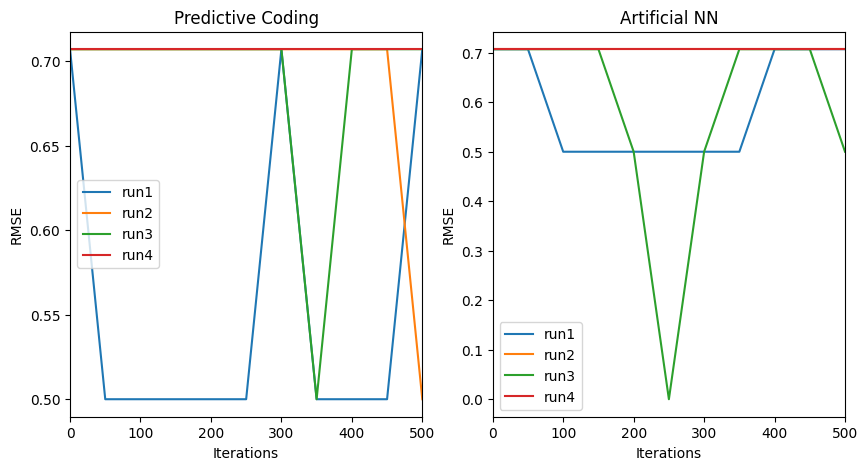

In [52]:
import matplotlib.pyplot as plt

# Example code

params = {
    'type': 'tanh',
    'l_rate': 0.2,
    'it_max': 100,
    'epochs': 500,
    'd_rate': 0,
    'beta': 0.2,
    'neurons': [2, 5, 1],
    'n_layers': 3
}
params['var'] = np.ones(params['n_layers'])
params['var'][-1] = 10

sin = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
sout = np.array([[1, 0, 0, 1]])

plotevery = 50
run_num = 4

rms_error_pc = np.zeros((run_num, (params['epochs'] // plotevery) + 1))
rms_error_ann = np.zeros((run_num, (params['epochs'] // plotevery) + 1))

for run in range(run_num):
    w_pc, b_pc = w_init(params)
    w_ann, b_ann = w_pc.copy(), b_pc.copy()

    counter = 0
    rms_error_pc[run, counter] = test(sin, sout, w_pc, b_pc, params)
    rms_error_ann[run, counter] = test(sin, sout, w_ann, b_ann, params)

    for epoch in range(1, params['epochs'] + 1):
        params['epoch_num'] = epoch

        w_pc, b_pc = learn_pc(sin, sout, w_pc, b_pc, params)
        w_ann, b_ann = learn_ann(sin, sout, w_ann, b_ann, params)

        if (epoch / params['epochs']) * (params['epochs'] / plotevery) == np.ceil((epoch / params['epochs']) * (params['epochs'] / plotevery)):
            counter += 1
            rms_error_pc[run, counter] = test(sin, sout, w_pc, b_pc, params)
            rms_error_ann[run, counter] = test(sin, sout, w_ann, b_ann, params)

leg = ['run1', 'run2', 'run3', 'run4']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, params['epochs'] + 1, plotevery), rms_error_pc.T)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Predictive Coding')
plt.legend(leg)
plt.xlim([0, params['epochs']])

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, params['epochs'] + 1, plotevery), rms_error_ann.T)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Artificial NN')
plt.legend(leg)
plt.xlim([0, params['epochs']])
plt.show()